In [10]:
import numpy as np
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import ndimage

import sys
from PIL import Image
from glob import glob
import h5py
import time

In [4]:
big_x = []
for i in range(4):
    loaded_arr = np.loadtxt("bx_"+str(i)+".txt")
    big_x.append(loaded_arr.reshape(loaded_arr.shape[0], loaded_arr.shape[1] // 21, 21))
loaded_y = np.loadtxt("by.txt")

ValueError: cannot reshape array of size 3240000 into shape (40000,49,9)

In [6]:
big_y = loaded_y.reshape(loaded_y.shape[0], loaded_y.shape[1] // 9, 9)

In [71]:
big_lil_x = []
for i in range(4):
    big_lil_x.append(big_x[i][:, ::3, ::3])
print(big_lil_x[0].shape)
print(big_x[0].shape)
print(big_y.shape)

(40000, 7, 7)
(40000, 21, 21)
(40000, 9, 9)


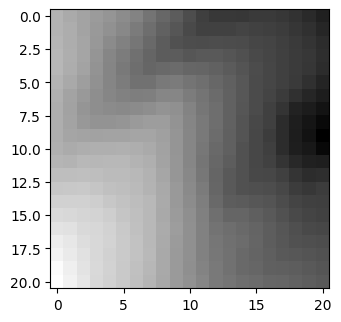

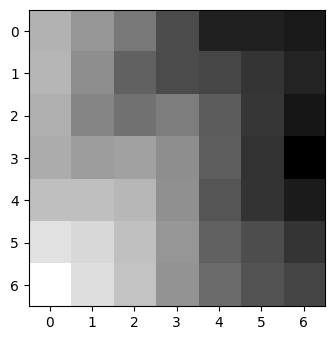

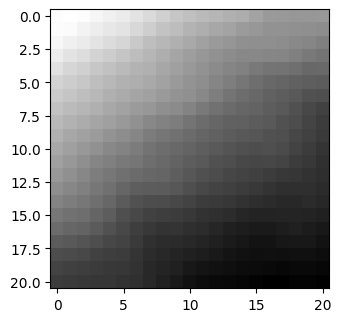

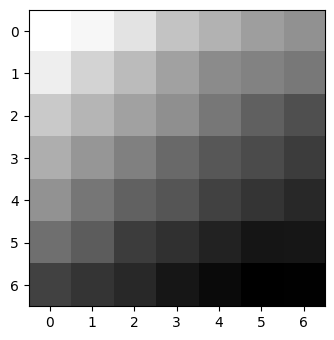

In [17]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [3.5, 3.5]
plt.rcParams["figure.autolayout"] = True
plt.imshow(big_x[0][0], cmap='gray')

# Display the plot
plt.show()
plt.imshow(big_lil_x[0][0], cmap='gray')

# Display the plot
plt.show()

plt.imshow(big_x[0][20], cmap='gray')

# Display the plot
plt.show()
plt.imshow(big_lil_x[0][20], cmap='gray')

# Display the plot
plt.show()

In [18]:
## do super resolution lmao
## import TF stuff
import tensorflow as tf
import tensorflow.keras.layers
import tensorflow.keras.utils as kr_utils
import tensorflow.keras.regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, MaxPooling2D, Add, BatchNormalization, Dropout, Flatten, Input, InputLayer, Conv2D, ReLU, Concatenate, GlobalAveragePooling2D, LeakyReLU, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import ModelCheckpoint

In [42]:
def edsr_block(x_in, conv_fs):
    #y = x_in
    y = Conv2D(kernel_size=1, filters=conv_fs, strides=1, padding="same", activation="relu")(x_in)
    y = ReLU()(y)
    y = Conv2D(kernel_size=1, filters=conv_fs, strides=1, padding="same")(y)
    y = Add()([x_in, y])
    
    return y

def upsample_block(x_in, factor):
    spl = Lambda(lambda y:tf.nn.depth_to_space(y, block_size=2))
    x = Conv2D(2048 * (factor ** 2), 3, padding="same")(x_in)
    x = spl(x)
    x = Conv2D(2048 * (factor ** 2), 3, padding="same")(x)
    x = spl(x)
    return x

def usb2(x_in, factor):
    usl = Conv2D(7 * (factor ** 2), 3, padding='same')(x_in)
    sfl = Lambda(function=lambda x: tf.nn.depth_to_space(x, factor))(usl)
    usl = Conv2D(7 * (factor ** 2), 3, padding='same')(sfl)
    sfl = Lambda(function=lambda x: tf.nn.depth_to_space(x, factor))(usl)
    return sfl

def make_edsr(in_shape, n_additional_res_blocks):
    spl = Lambda(lambda y:tf.nn.depth_to_space(y, block_size=2))
    sq_in = Input(shape=in_shape)
    sq = Conv2D(kernel_size=(5,5), filters=8, strides=1, padding='same', activation="relu")(sq_in)
    sq1 = edsr_block(sq, 8)
    for i in range(n_additional_res_blocks):
        sq1 = edsr_block(sq, 8)
    sq2 = Conv2D(kernel_size=(3,3), filters=8, strides=1,padding='same', activation="relu")(sq1)
    sq3 = Add()([sq, sq2])
    sq4a= usb2(sq3, 3)
    sq5 = Conv2D(kernel_size=(3,3), filters=1, strides=3,padding='valid', activation="relu")(sq4a)
    model = Model(sq_in, sq5)
    return model
    

In [43]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

In [46]:
edsr_ish = make_edsr((7, 7, 1), 3)
edsr_ish.compile(loss="mae")#, metrics=[PSNR])
print(edsr_ish.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 7, 7, 1)]    0           []                               
                                                                                                  
 conv2d_105 (Conv2D)            (None, 7, 7, 8)      208         ['input_10[0][0]']               
                                                                                                  
 conv2d_112 (Conv2D)            (None, 7, 7, 8)      72          ['conv2d_105[0][0]']             
                                                                                                  
 re_lu_35 (ReLU)                (None, 7, 7, 8)      0           ['conv2d_112[0][0]']             
                                                                                            

In [47]:
edsr_ish.fit(x = big_lil_x[0][:-4000], y = big_x[0][:-4000], epochs=100)

Epoch 1/100
1125/1125 [==============================] - 54s 46ms/step - loss: 186.7636
Epoch 2/100
1125/1125 [==============================] - 47s 42ms/step - loss: 112.6813
Epoch 3/100
1125/1125 [==============================] - 59s 53ms/step - loss: 99.9328
Epoch 4/100
1125/1125 [==============================] - 66s 58ms/step - loss: 91.7187
Epoch 5/100
1125/1125 [==============================] - 55s 48ms/step - loss: 86.1226
Epoch 6/100
1125/1125 [==============================] - 47s 42ms/step - loss: 82.0456
Epoch 7/100
1125/1125 [==============================] - 43s 38ms/step - loss: 78.4333
Epoch 8/100
1125/1125 [==============================] - 41s 37ms/step - loss: 75.5127
Epoch 9/100
1125/1125 [==============================] - 52s 46ms/step - loss: 72.4097
Epoch 10/100
1125/1125 [==============================] - 59s 52ms/step - loss: 69.6107
Epoch 11/100
1125/1125 [==============================] - 51s 45ms/step - loss: 66.8972
Epoch 12/100
1125/1125 [===============

1125/1125 [==============================] - 36s 32ms/step - loss: 29.2426
Epoch 95/100
1125/1125 [==============================] - 37s 33ms/step - loss: 29.1678
Epoch 96/100
1125/1125 [==============================] - 38s 34ms/step - loss: 29.0569
Epoch 97/100
1125/1125 [==============================] - 37s 33ms/step - loss: 29.0851
Epoch 98/100
1125/1125 [==============================] - 41s 36ms/step - loss: 29.0682
Epoch 99/100
1125/1125 [==============================] - 43s 39ms/step - loss: 29.0016
Epoch 100/100
1125/1125 [==============================] - 38s 34ms/step - loss: 28.9819


In [87]:
predictions = []
ogs_lr = []
ogs_hr = []
ans = []
for i in range(4000):
    predictions.append(np.array(edsr_ish(np.array([[big_lil_x[0][-4000+i]]]).reshape((1, 7, 7, 1))))[0].astype(np.uint8))
    ogs_lr.append(big_lil_x[0][-4000+i])
    ogs_hr.append(big_x[0][-4000+i])
    ans.append(big_y[-4000+i])

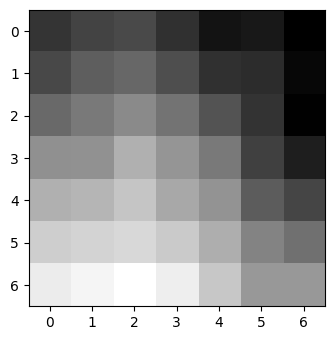

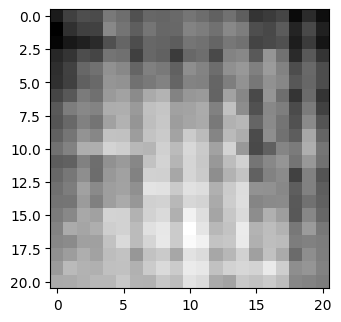

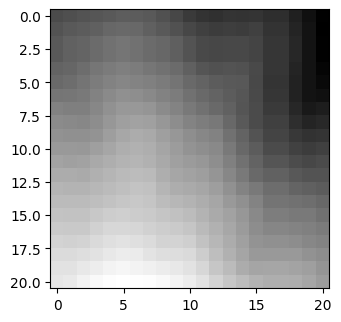

In [118]:
i = 140
plt.imshow(ogs_lr[i], cmap='gray')

# Display the plot
plt.show()
plt.imshow(predictions[i], cmap='gray')

# Display the plot
plt.show()
plt.imshow(ogs_hr[i], cmap='gray')
plt.show()

In [137]:
### generate with linear and sampling...
### linear
import math
predictions_lin = []
for i in range(4000):
    seven = big_lil_x[0][-4000+i]
    #print(seven.shape)
    temp = np.zeros((21, 21))
    ### temp[i, j] = dist/t
    for j in range(21):
        for k in range(21):
            if j%3 == 0 and k%3 == 0:
                temp[j, k] = seven[j//3, k//3]
            else:
                w1 = (j%3)**2 + (k%3)**2
                w2 = (3-(j%3))**2 + (k%3)**2
                w3 = (j%3)**2 + (3-(k%3))**2
                w4 = (3-(j%3))**2 + (3-(k%3))**2
                t2 = w1 + w2 + w3 + w4
                nw1 = w1/t2
                nw2 = w2/t2
                nw3 = w3/t2
                nw4 = w4/t2
                
                temp[j, k] = nw4*seven[j//3, k//3] +\
                            nw3*seven[min(j//3+1, 6), k//3] +\
                            nw2*seven[j//3, min(k//3+1, 6)] +\
                            nw1*seven[min(j//3+1, 6), min(k//3+1, 6)]
    predictions_lin.append(temp)

In [133]:
print(len(predictions_lin))

4000


In [140]:
predictions_sam = []
for i in range(4000):
    temp = np.zeros((21, 21))
    for j in range(21):
        for k in range(21):
            temp[j, k] = big_lil_x[0][-4000+i, j//3, k//3]
    predictions_sam.append(temp)

In [141]:
data1 = []
for i in range(len(predictions)):
    for j in range(3):
        for k in range(3):
            data1.append(predictions[i][j*7: j*7 + 7, k*7: k*7+7].flatten())
data2 = []
for i in range(len(predictions_lin)):
    for j in range(3):
        for k in range(3):
            data2.append(predictions_lin[i][j*7: j*7 + 7, k*7: k*7+7].flatten())
    
data3 = []
for i in range(len(predictions_sam)):
    for j in range(3):
        for k in range(3):
            data3.append(predictions_sam[i][j*7: j*7 + 7, k*7: k*7+7].flatten())
    
ansi = []
for i in range(len(ans)):
    for j in range(3):
        for k in range(3):
            ansi.append(np.mean(big_y[j*3:j*3+3, k*3:k*3+3]))
    

In [142]:
print(len(data1))

36000


In [143]:
from sklearn.ensemble import RandomForestRegressor

rf1 = RandomForestRegressor(n_estimators=100)
rf1.fit(data1[:1000], ansi[:1000])

rf2 = RandomForestRegressor(n_estimators=100)
rf2.fit(data2[:1000], ansi[:1000])

rf3 = RandomForestRegressor(n_estimators=100)
rf3.fit(data3[:1000], ansi[:1000])

RandomForestRegressor()

In [144]:
from sklearn.metrics import mean_squared_error

In [145]:
print(mean_squared_error(rf1.predict(data1[1000:2000]), ansi[1000:2000], squared=False))
print(mean_squared_error(rf2.predict(data2[1000:2000]), ansi[1000:2000], squared=False))
print(mean_squared_error(rf3.predict(data3[1000:2000]), ansi[1000:2000], squared=False))

0.004507874349640905
0.01172035474120973
0.011116343869820945


<BarContainer object of 3 artists>

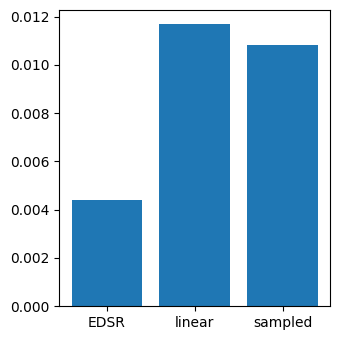

In [146]:
plt.bar(["EDSR", "linear", "sampled"], [0.004419044968789485, 0.01168859867140356, 0.010836170891562155])

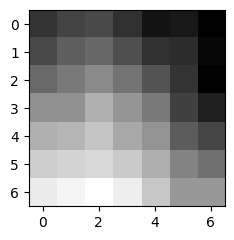

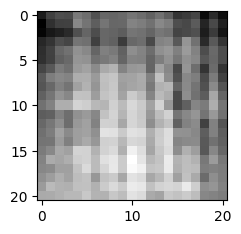

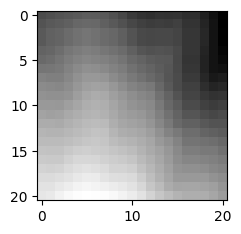

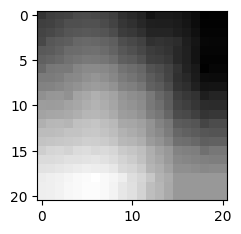

In [148]:
i = 140
plt.rcParams["figure.figsize"] = [2.5, 2.5]
plt.imshow(ogs_lr[i], cmap='gray')

# Display the plot
plt.show()
plt.imshow(predictions[i], cmap='gray')

# Display the plot
plt.show()
plt.imshow(ogs_hr[i], cmap='gray')
plt.show()

plt.imshow(predictions_lin[i], cmap='gray')
plt.show()